In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
c_data = pd.read_csv('../data/data_cleaned.csv')

In [3]:
c_data.head(10)

,Bankrupt?,ROA(C)_before_interest_and_depreciation_before_interest,ROA(A)_before_interest_and_%_after_tax,ROA(B)_before_interest_and_depreciation_after_tax,Operating_Gross_Margin,Realized_Sales_Gross_Margin,Operating_Profit_Rate,Pre-tax_net_Interest_Rate,After-tax_net_Interest_Rate,Non-industry_income_and_expenditure/revenue,...,Liability-Assets_Flag,Net_Income_to_Total_Assets,Total_assets_to_GNP_price,No-credit_Interval,Gross_Profit_to_Sales,Net_Income_to_Stockholder's_Equity,Liability_to_Equity,Degree_of_Financial_Leverage_(DFL),Interest_Coverage_Ratio_(Interest_expense_to_EBIT),Equity_to_Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490
5,1,0.388680,0.415177,0.419134,0.590171,0.590251,0.998758,0.796903,0.808771,0.303116,...,0,0.710420,0.005278,0.622605,0.590172,0.829939,0.285087,0.026675,0.564538,0.019534
6,0,0.390923,0.445704,0.436158,0.619950,0.619950,0.998993,0.797012,0.808960,0.302814,...,0,0.736619,0.018372,0.623655,0.619949,0.829980,0.292504,0.026622,0.564200,0.015663
7,0,0.508361,0.570922,0.559077,0.601738,0.601717,0.999009,0.797449,0.809362,0.303545,...,0,0.815350,0.010005,0.623843,0.601739,0.841459,0.278607,0.027031,0.566089,0.034889
8,0,0.488519,0.545137,0.543284,0.603612,0.603612,0.998961,0.797414,0.809338,0.303584,...,0,0.803647,0.000824,0.623977,0.603613,0.840487,0.276423,0.026891,0.565592,0.065826
9,0,0.495686,0.550916,0.542963,0.599209,0.599209,0.999001,0.797404,0.809320,0.303483,...,0,0.804195,0.005798,0.623865,0.599205,0.840688,0.279388,0.027243,0.566668,0.030801


There are many features to choose from the data-set and we do not know which variables are critical to our target variable(Bankruptcy). Before analyzing further into the data, we will lay down scatter plots on few interesting features to see if we can observe any patterns. We will choose one constant variable and compare to multiple other variables to define if any patterns exists between Bankrupt and Survived companies.<br>
For the constant variable I have chosen ROA(A) before interest and % after tax as After tax return on assets(ROA) is a financial ratio used to measure after-tax income earned by a company from its assets.<br>
As for comparison variables I have chosen the following:
- ROA(B) before interest and depreciation after tax
- ROA(C) before interest and depreciation before interest
- Cash/Total Assets
- Net profit before tax/Paid in capital
- Net worth/Assets
- Total Assets Growth Rate
- Realized Sales Gross Margin
- Debt ratio%

First, define the 0 and 1 in Bankrupt column as No and Yes.

In [4]:
di_bank = {0:'No', 1:'Yes'}
d_data = c_data.replace({'Bankrupt?':di_bank})
d_data.head()

,Bankrupt?,ROA(C)_before_interest_and_depreciation_before_interest,ROA(A)_before_interest_and_%_after_tax,ROA(B)_before_interest_and_depreciation_after_tax,Operating_Gross_Margin,Realized_Sales_Gross_Margin,Operating_Profit_Rate,Pre-tax_net_Interest_Rate,After-tax_net_Interest_Rate,Non-industry_income_and_expenditure/revenue,...,Liability-Assets_Flag,Net_Income_to_Total_Assets,Total_assets_to_GNP_price,No-credit_Interval,Gross_Profit_to_Sales,Net_Income_to_Stockholder's_Equity,Liability_to_Equity,Degree_of_Financial_Leverage_(DFL),Interest_Coverage_Ratio_(Interest_expense_to_EBIT),Equity_to_Liability
0,Yes,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,Yes,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,Yes,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,Yes,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,Yes,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490


Plot the Scatter plots

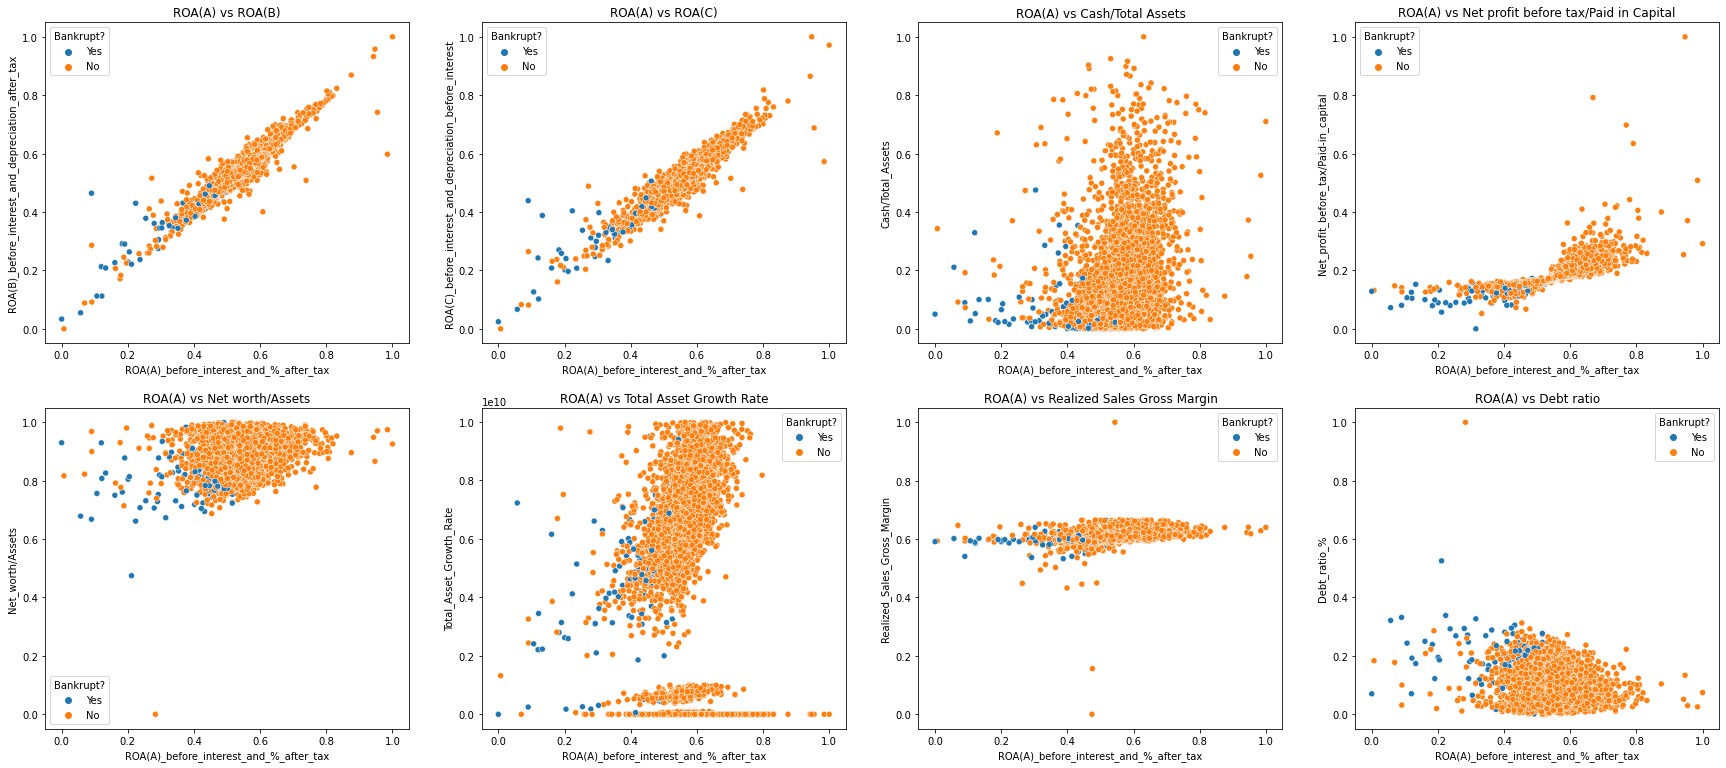

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30,13))
sns.scatterplot(x='ROA(A)_before_interest_and_%_after_tax',y='ROA(B)_before_interest_and_depreciation_after_tax',hue='Bankrupt?',data=d_data, ax=axs[0][0])
sns.scatterplot(x='ROA(A)_before_interest_and_%_after_tax',y='ROA(C)_before_interest_and_depreciation_before_interest',hue='Bankrupt?',data=d_data, ax=axs[0][1])
sns.scatterplot(x='ROA(A)_before_interest_and_%_after_tax',y='Cash/Total_Assets',hue='Bankrupt?',data=d_data, ax=axs[0][2])
sns.scatterplot(x='ROA(A)_before_interest_and_%_after_tax',y='Net_profit_before_tax/Paid-in_capital',hue='Bankrupt?',data=d_data, ax=axs[0][3])

sns.scatterplot(x='ROA(A)_before_interest_and_%_after_tax',y='Net_worth/Assets',hue='Bankrupt?',data=d_data, ax=axs[1][0])
sns.scatterplot(x='ROA(A)_before_interest_and_%_after_tax',y='Total_Asset_Growth_Rate',hue='Bankrupt?',data=d_data, ax=axs[1][1])
sns.scatterplot(x='ROA(A)_before_interest_and_%_after_tax',y='Realized_Sales_Gross_Margin',hue='Bankrupt?',data=d_data, ax=axs[1][2])
sns.scatterplot(x='ROA(A)_before_interest_and_%_after_tax',y='Debt_ratio_%',hue='Bankrupt?',data=d_data, ax=axs[1][3])

axs[0][0].set_title('ROA(A) vs ROA(B)');
axs[0][1].set_title('ROA(A) vs ROA(C)');
axs[0][2].set_title('ROA(A) vs Cash/Total Assets');
axs[0][3].set_title('ROA(A) vs Net profit before tax/Paid in Capital');

axs[1][0].set_title('ROA(A) vs Net worth/Assets');
axs[1][1].set_title('ROA(A) vs Total Asset Growth Rate');
axs[1][2].set_title('ROA(A) vs Realized Sales Gross Margin');
axs[1][3].set_title('ROA(A) vs Debt ratio');

Before analyzing through the scatter plots, there is a noticable pattern on all of the plots.<br>
Majority of the bankrupted companies consists of lower Return on Assets (ROA) values. This could signify Bankrupt companies are less efficient in managing its assets to generate earnings as ROA is a indicator of the profitability in relative to company's total assets.

Exploiting through the scatter plots, we can also observe the following:
1. ROA(A) vs ROA(B) & ROA(C) reveals a linear pattern and bankrupted companies are concentraed in lower end of the plot compared to survived. 
2. The Survived Companies tends to have higher contents of Cash/Total Assets ratio which measures the portion of company's assets held in cash or marketable securities. This could indicate that survived companies survived due to higher degree of Cash held in the company as safety net.
3. Debt Ratio, which defines the ratio of total debt to total assets, on brankrupt companies shows slightly higher values compared to survived companies. This could signify that bankrupted companies may have higher portion of liabilities than assets.
4. Net worth/Assets, Total Asset growth rate, Realized sales gross Margin have very low difference between the values and the pattern seems to be insignificant to verifying target variable. However, The survived companies appears to have slightly higher values in Net profit/Paid in Capital

#### Heatmap check
Now, we will check the correlation between columns of the entire data-set through the Heatmap

In [6]:
corr_df = c_data.corr()

<AxesSubplot:>

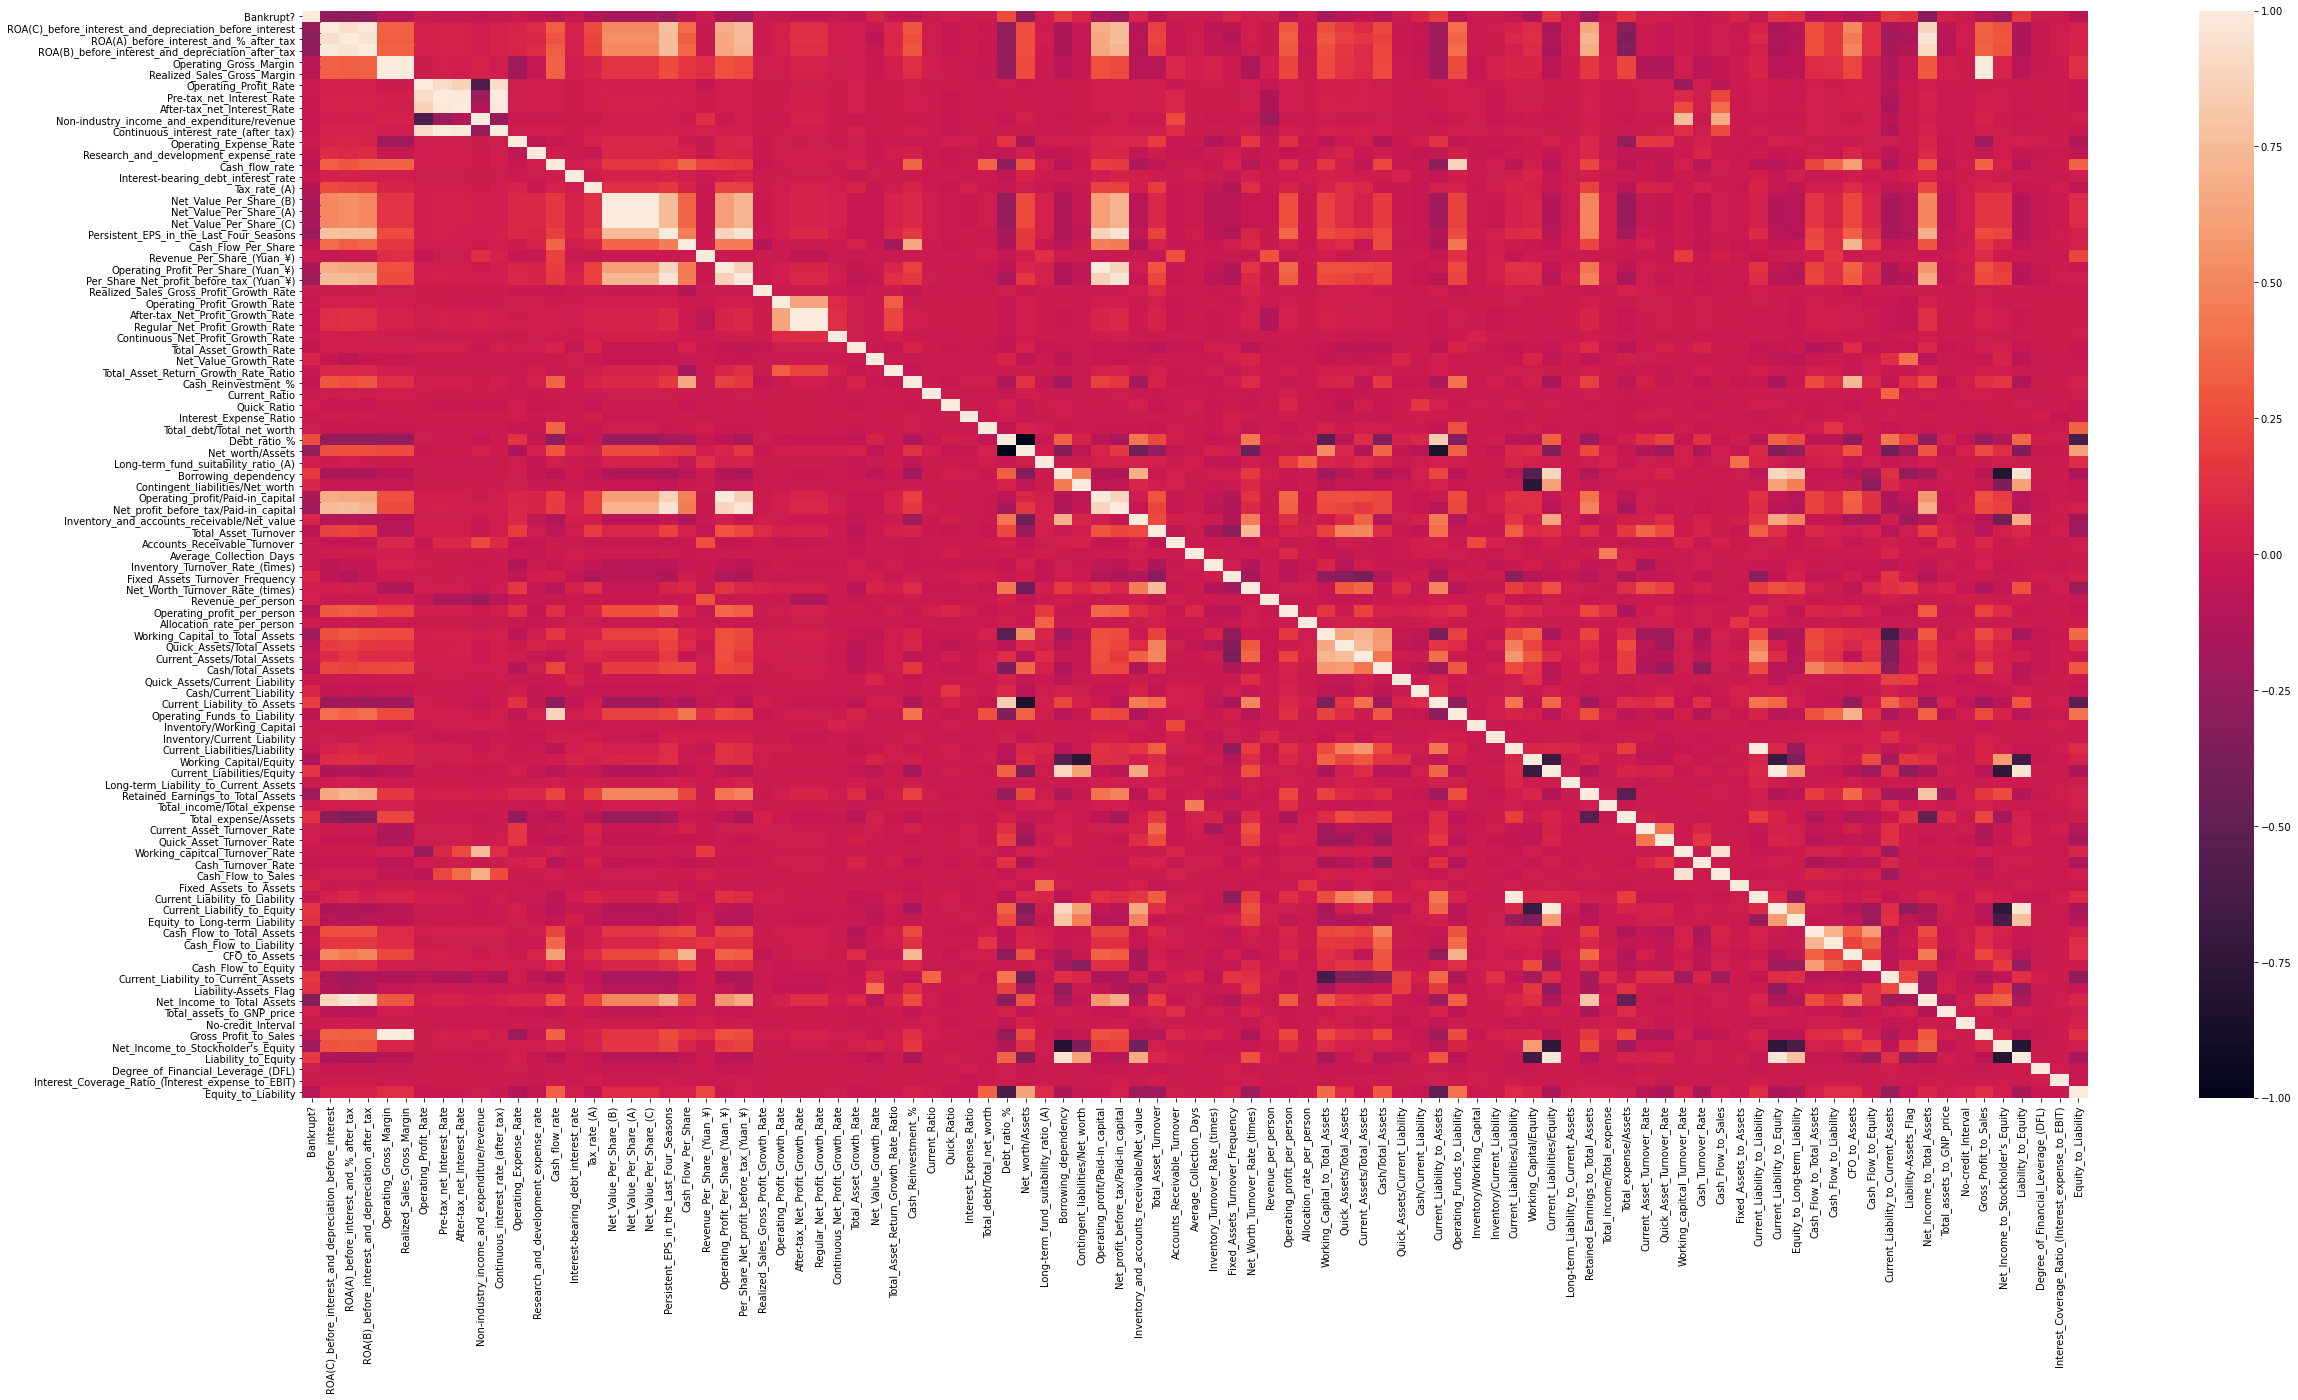

In [7]:
plt.figure(figsize=(40,20))
sns.heatmap(corr_df)

At first glance through the heatmap we can notice two aspects: <br>
- There are too many features presented. Not all features will have significant influence on the analysis. Thus, we should identify which features have the least impact and to be removed from the data-set. This will be done through Feature selection. <br>
- There are variables which measures extremely close to -1 or 1. This signifies that some of the features are highly correlated with each other and are likely to have high colinearity and be redundant. 

#### Multicollinearity Check
High correlation between the indepent variables in the regression analysis could impact overall interpretation of the result.
In this case, the heatmap does not specify or show if information in the variable is explained in multiple other variables. however, the high correlated relation between the features in some groups could represent that some feature may provide redundant and duplicate infomration of each other. To address the issue, it may help to identify and drop these features that have correlation coefficient above 0.95 or below -0.95 to avoid multicollinearity in the variables.

First I will create correlation matrix by removing the target variable = Bankrupt

In [8]:
correlation_matrix = c_data.drop(['Bankrupt?'], axis =1).corr()

In [9]:
avoid_list = [] # Create empty list for columns to drop
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > 0.95: # Check correlation coefficient above 0.95 or below -0.95
            if correlation_matrix.columns[j] not in avoid_list:
                avoid_list.append(correlation_matrix.columns[j])

In [10]:
print("The number of variables that consists of high correlation is:",len(avoid_list))

The number of variables that consists of high correlation is: 17


Now we will drop the variable from the data and create a new data-set

In [11]:
cc_data = c_data.drop(avoid_list, axis=1)
len(cc_data.columns)

78

The final number of columns after filtering the variable that could potentially have duplicate/reduant information is 78

#### Feature Selection
The data-set has large number of features. In order to make EDA easier, we need to reduce the number of features on the data.<br>
For the feature selection I have used Backward Elimination method. Backward Elimination method, which is common technique of  wrapper method, starts with all the features and removes the least significant feature at each iteration which improves the performance of the model. The process repeats until there are no further improvement observed on removal of the features. The performance metric used to evaluate the performance of the feature is by using P-value. We set the significance level and remove the feature depending on if the value is above or below.

The steps in Backward Elimination method is as follows: 
- First, select the significance level (P-value) as 5%(0.05).
- Fit the model with all the features selected.
- Identify the predictor with the highest P-value
- If the P-value identified is greater than the set significance level, we remove the feature from the column
- Once the feature is removed we fit the model again with the new data-set.
- Iterate the process until the highest P-value in the data-set is less than 0.05 and features are filtered out.

First step is to seperate the Feature Matrix(X) and Target variable(y)

In [12]:
X = cc_data.drop(['Bankrupt?'],axis=1)
y = cc_data['Bankrupt?']

In [13]:
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index=cols)
    pmax= max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features = cols

In [14]:
print("The Selected columns are: \n",selected_features)

The Selected columns are: 
 ['Operating_Profit_Rate', 'Non-industry_income_and_expenditure/revenue', 'Continuous_interest_rate_(after_tax)', 'Tax_rate_(A)', 'Net_worth/Assets', 'Contingent_liabilities/Net_worth', 'Operating_profit/Paid-in_capital', 'Inventory_and_accounts_receivable/Net_value', 'Fixed_Assets_Turnover_Frequency', 'Net_Worth_Turnover_Rate_(times)', 'Revenue_per_person', 'Operating_profit_per_person', 'Working_Capital_to_Total_Assets', 'Quick_Assets/Total_Assets', 'Current_Assets/Total_Assets', 'Cash/Current_Liability', 'Current_Liability_to_Assets', 'Operating_Funds_to_Liability', 'Retained_Earnings_to_Total_Assets', 'Cash_Turnover_Rate', 'Fixed_Assets_to_Assets', 'Current_Liability_to_Liability', 'Cash_Flow_to_Equity', 'Current_Liability_to_Current_Assets', 'Liability-Assets_Flag', 'Net_Income_to_Total_Assets', "Net_Income_to_Stockholder's_Equity", 'Liability_to_Equity', 'Equity_to_Liability']


In [15]:
print("The number of features reduced down to:", len(selected_features))

The number of features reduced down to: 29


In [16]:
new_columns = ['Bankrupt?','Operating_Profit_Rate', 'Non-industry_income_and_expenditure/revenue', 'Continuous_interest_rate_(after_tax)', 'Tax_rate_(A)', 'Net_worth/Assets', 'Contingent_liabilities/Net_worth', 'Operating_profit/Paid-in_capital', 'Inventory_and_accounts_receivable/Net_value', 'Fixed_Assets_Turnover_Frequency', 'Net_Worth_Turnover_Rate_(times)', 'Revenue_per_person', 'Operating_profit_per_person', 'Working_Capital_to_Total_Assets', 'Quick_Assets/Total_Assets', 'Current_Assets/Total_Assets', 'Cash/Current_Liability', 'Current_Liability_to_Assets', 'Operating_Funds_to_Liability', 'Retained_Earnings_to_Total_Assets', 'Cash_Turnover_Rate', 'Fixed_Assets_to_Assets', 'Current_Liability_to_Liability', 'Cash_Flow_to_Equity', 'Current_Liability_to_Current_Assets', 'Liability-Assets_Flag', 'Net_Income_to_Total_Assets', "Net_Income_to_Stockholder's_Equity", 'Liability_to_Equity', 'Equity_to_Liability']
sel_data = cc_data[new_columns]
sel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Bankrupt?                                    6819 non-null   int64  
 1   Operating_Profit_Rate                        6819 non-null   float64
 2   Non-industry_income_and_expenditure/revenue  6819 non-null   float64
 3   Continuous_interest_rate_(after_tax)         6819 non-null   float64
 4   Tax_rate_(A)                                 6819 non-null   float64
 5   Net_worth/Assets                             6819 non-null   float64
 6   Contingent_liabilities/Net_worth             6819 non-null   float64
 7   Operating_profit/Paid-in_capital             6819 non-null   float64
 8   Inventory_and_accounts_receivable/Net_value  6819 non-null   float64
 9   Fixed_Assets_Turnover_Frequency              6819 non-null   float64
 10  

<AxesSubplot:>

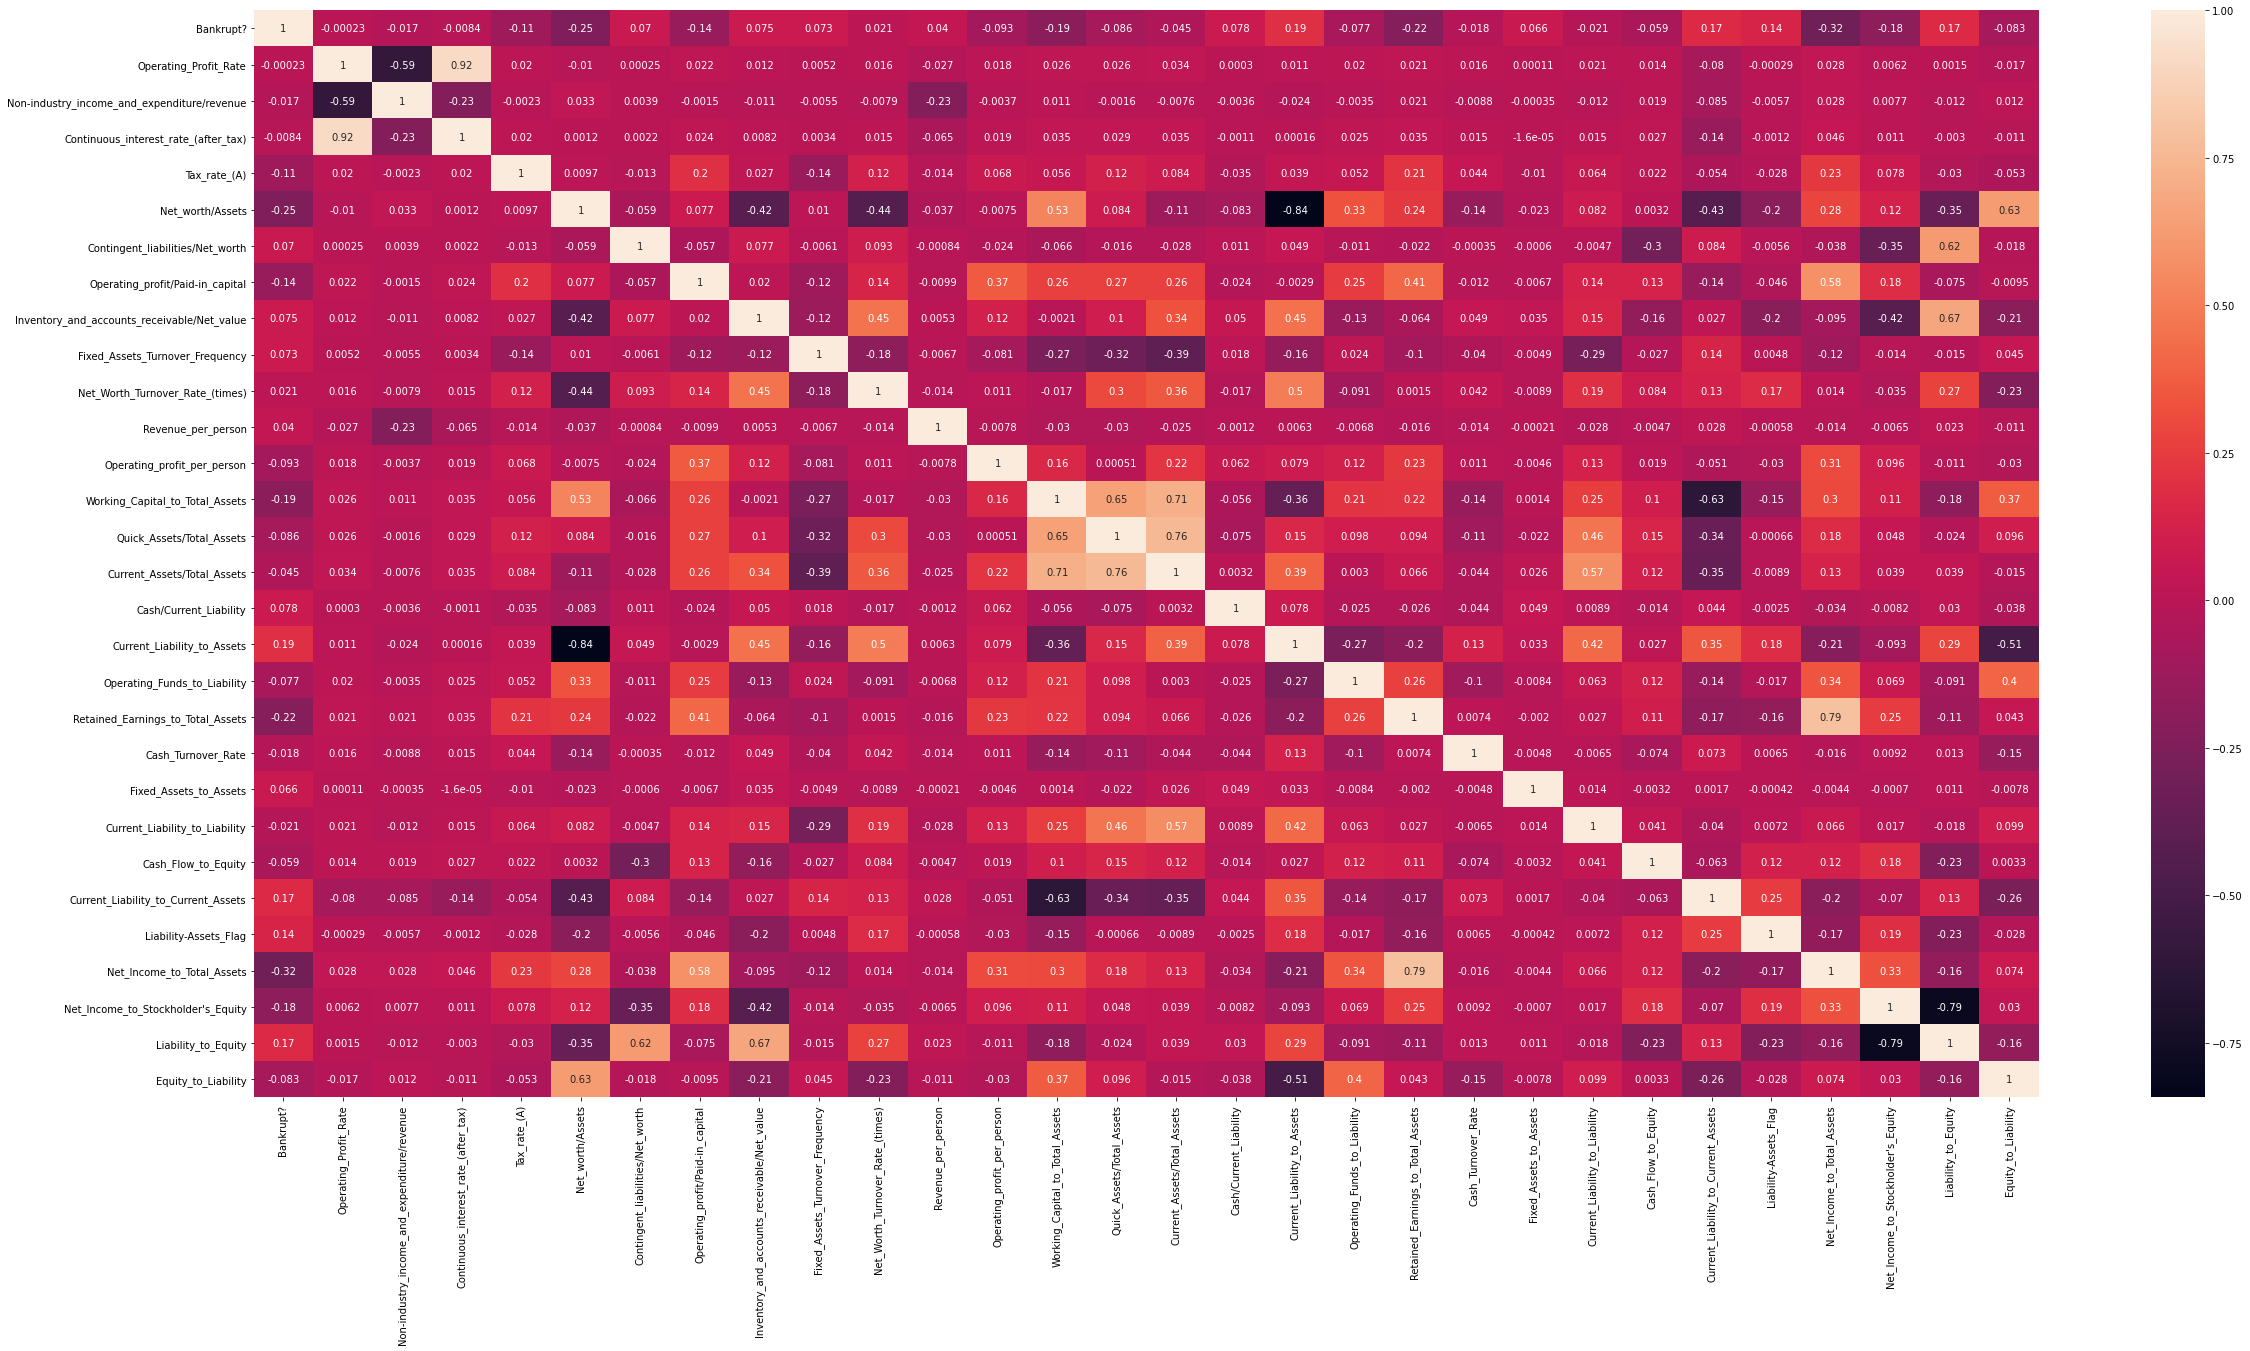

In [17]:
corr_sel = sel_data.corr()
plt.figure(figsize=(40,20))
sns.heatmap(corr_sel, annot=True)

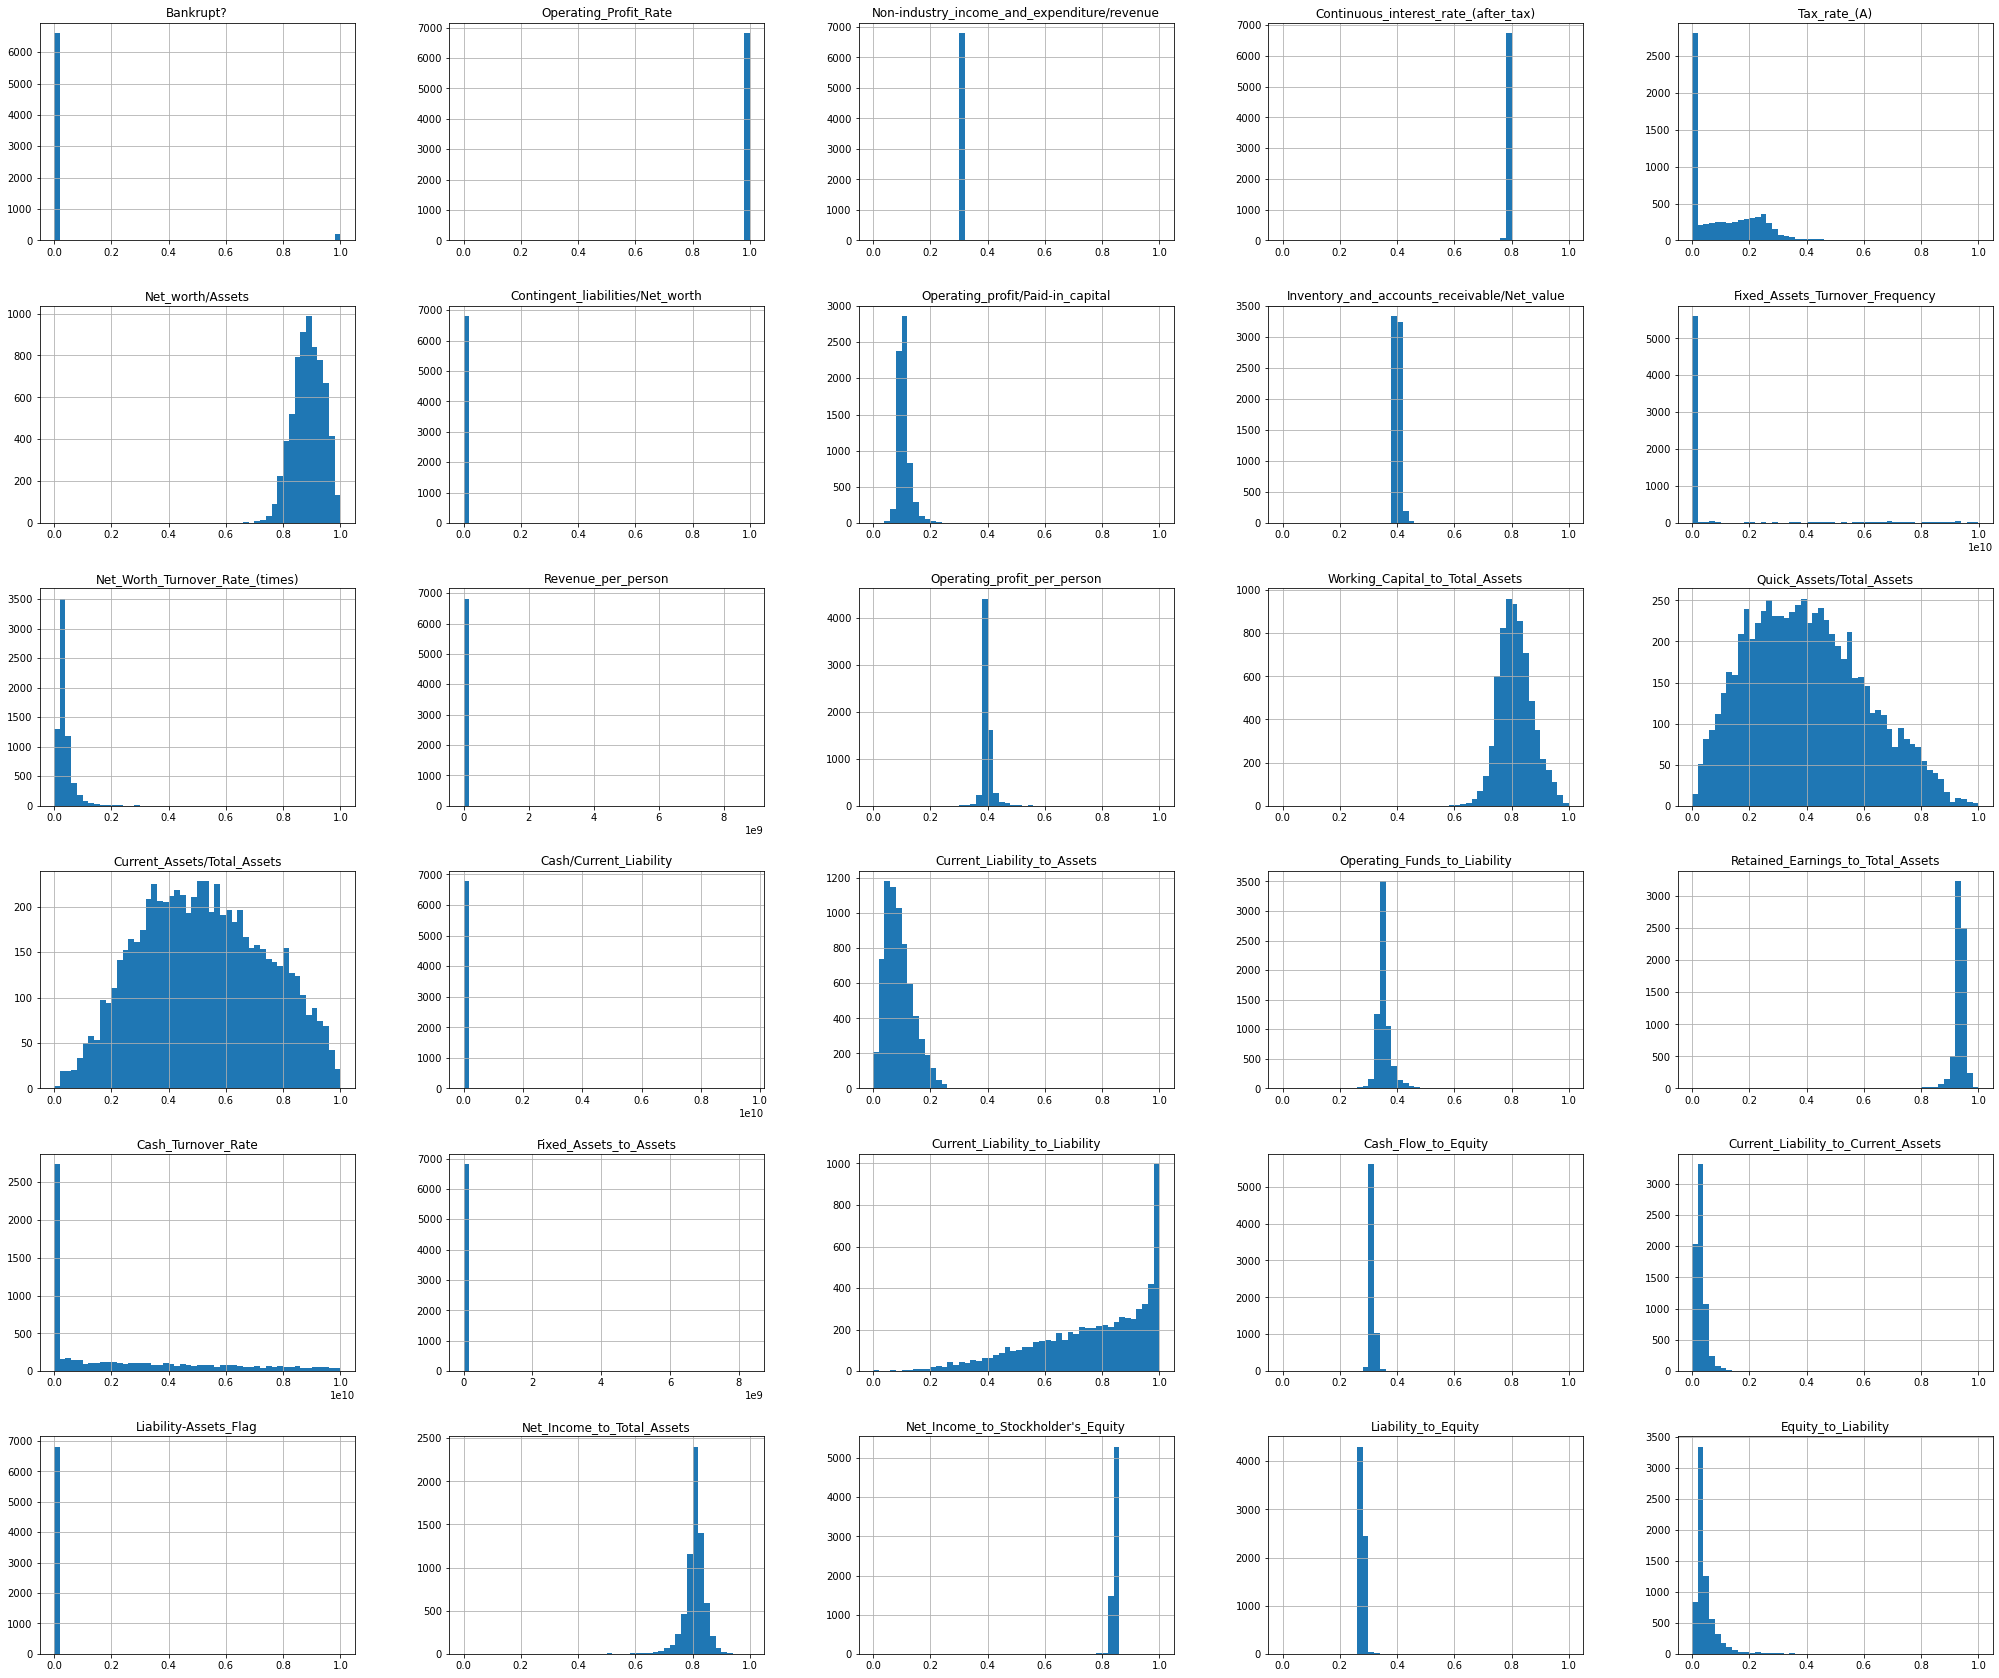

In [18]:
sel_data.hist(figsize=(35,30),bins=50)
plt.show()

#### Box plots for Analysis
I have seperated the analysis into 4 Major Categories utilizing the Boxplot on Bankrupt vs Survived companies:
- Asset ratios
- Liability ratios
- Accounting
- Operation

In [19]:
di = {0:'No', 1:'Yes'}
cat_data = sel_data.replace({'Bankrupt?':di})

#### Assets Analysis

In this section, there are 4 sub-categories which divides the data-set into asset classes. 
1. Current_Assets/Total_Assets = A ratio between current assets and total assets is a ratio to determine economic value for or within one year to all current assets. Ratio helps to measure the short-term liquidity of the company, or its ability to generate enough cash to pay off all debts should they become due at once. 
2. Quick Assets/Total Assets = Similar to Current Assets ratio, Quick Assets ratio helps to measure the liquidity of the company but excluding inventory, and other less liquid assets and focuses on the company's most liquid assets.
3. Net worth/Assets = Measures the amount of equity the business has when compared to the total assets owned by the business. Higher Net_worth to Asset ratio, the less leveraged the company is, meaning that a larger percentage of its assets are owned by the company and its investors
4. Working Capital/Total Assets = A ratio that compares the net liquid assets to the total assets of the firm. The ratio is an indicator of the short term liquidity and financial strength of the business and indicates it's ability to finance short term obligations.

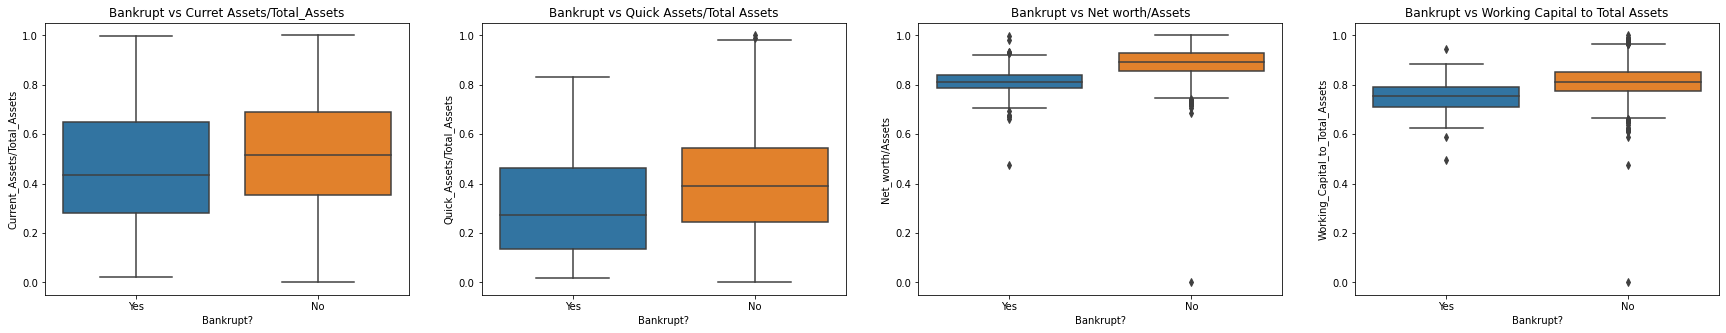

In [20]:
fig, axs = plt.subplots(ncols=4, figsize=(30,5))
sns.boxplot(x='Bankrupt?',y='Current_Assets/Total_Assets', data=cat_data, ax=axs[0])
sns.boxplot(x='Bankrupt?',y='Quick_Assets/Total_Assets', data=cat_data, ax=axs[1])
sns.boxplot(x='Bankrupt?',y='Net_worth/Assets', data=cat_data, ax=axs[2])
sns.boxplot(x='Bankrupt?',y='Working_Capital_to_Total_Assets', data=cat_data, ax=axs[3])
axs[0].set_title('Bankrupt vs Curret Assets/Total_Assets');
axs[1].set_title('Bankrupt vs Quick Assets/Total Assets');
axs[2].set_title('Bankrupt vs Net worth/Assets');
axs[3].set_title('Bankrupt vs Working Capital to Total Assets');


In above boxplots, there is a significant difference between Bankrupt VS Survived in all of the Asset ratio variables:
- Surviving companies have higher ratio values on both Current Assets/Total Asset ratio & Quick Assets/Total Assets on average which presents that these companies are more probable of generating cash to pay off debts should they become due at once. Liquidity is critical to any company. If a company cannot meet its financial obligations, it is incresing the chance of bankruptcy.
- The Net worth/Assets presents big gap between survived and bankrupt companies. There is obvious difference between box plots as Survived companies show much higher ratio on interquartile Range.

#### Liabilitiy ratios Analysis

In this section, there are 4 sub-categories which divides the data-set into Liability classes. 

1. Current Liability to Assets = Debt to Asset ratio, current liabilities divided by the total amount of the company has in assets, whether short-term investments or long-term and capital assets.
2. Current Liability to Current Assets = Current liabilities are obligations expected to be paid within in one year to Current assets are those which can be converted in to cash within one year.
3. Equity to Liability = Also known as Debt-to-equity. is used to evaluate a company's financial leverage. measure of the degree to which compnay is financing its operations through debt vs wholly owned funds.
4. Current Liability to Liability = Company's short-term financial obligations that are due within one year or within a normal operating cycle to total liability

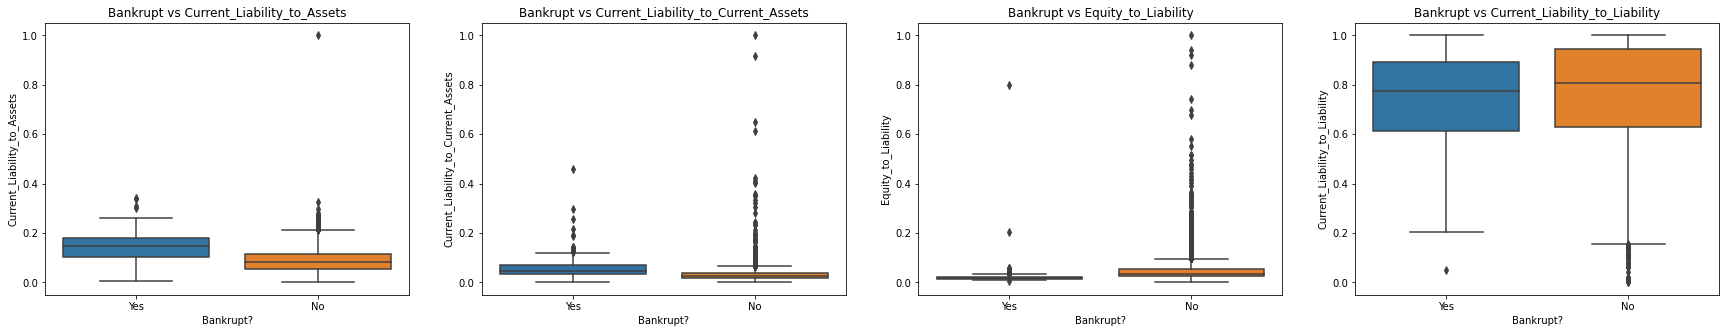

In [21]:
fig, axs = plt.subplots(ncols=4, figsize=(30,5))
sns.boxplot(x='Bankrupt?',y='Current_Liability_to_Assets', data=cat_data, ax=axs[0])
sns.boxplot(x='Bankrupt?',y='Current_Liability_to_Current_Assets', data=cat_data, ax=axs[1])
sns.boxplot(x='Bankrupt?',y='Equity_to_Liability', data=cat_data, ax=axs[2])
sns.boxplot(x='Bankrupt?',y='Current_Liability_to_Liability', data=cat_data, ax=axs[3])
axs[0].set_title('Bankrupt vs Current_Liability_to_Assets');
axs[1].set_title('Bankrupt vs Current_Liability_to_Current_Assets');
axs[2].set_title('Bankrupt vs Equity_to_Liability');
axs[3].set_title('Bankrupt vs Current_Liability_to_Liability');

Similar to the Assets ratios, the liabilities ratios presents similar patterns in comparison in reverse. Asset ratios overviews financial strength of the company and Liability ratios overview debts and obligations of the business.
In above box plots, we can observe that the difference between bankrupt and survived company is not so obvious as compared to the assets ratio variables However:

- Current liability to assets ratio presents clear gap between the target variables. The interquatile range on bankrupt companeis has much higher values which signifies that for these companies, current liability appears to share higher percentage in relation to their total assets. This could indicate that Surviving companies have higher portion of Assets to manage liabilities as compared to bankrupt companies.
- We can also see similar pattern in Current liability to Current assets. Although the difference between target variable is minor, Bankrupt companies have slight higher values in the ratio. As the ratio is defined as company's ability to convert assets to cash to pay of obligation in short term, this could signify that surviving companies are more probable to be financially stable in short term.
- Other than Current liability to assets, remaining plots shows minor differences and is mostly equivalent as per the variables.
- Also, it is noticeable that there are big portion of outliers in the plots

#### Accounting variables

In this section, there are 4 sub-categories which divides the data-set into Accounting variables

1. Net Income to Total Assets = Return on assets financial ratio that shows the percentage of profit a company earns in relation to its overall resources. how profitable a company is relative to its total assets.
2. Cash turnover Rate = Efficiency ratio that reveals the number of times that cash is turned over in an accounting period. Used to determine the proportion of cash required to generate sales.
3. Retained Earnings to Total Assets = Depicts the financial leverage of the entities, it indicates how assets were financed from retention of profit instead of paying profit out as dividents and acquiring loans.
4. Cash Flow to Equity = Calculates how much cash is available to the equity shareholders of a company after all expense, reinvestment and debt are paid

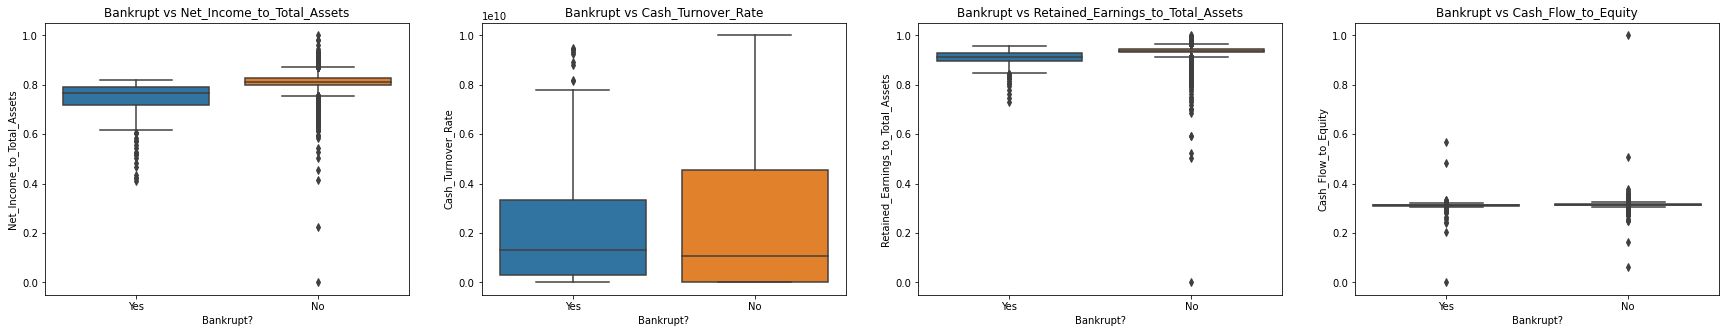

In [24]:
fig, axs = plt.subplots(ncols=4, figsize=(30,5))
sns.boxplot(x='Bankrupt?',y='Net_Income_to_Total_Assets', data=cat_data, ax=axs[0])
sns.boxplot(x='Bankrupt?',y='Cash_Turnover_Rate', data=cat_data, ax=axs[1])
sns.boxplot(x='Bankrupt?',y='Retained_Earnings_to_Total_Assets', data=cat_data, ax=axs[2])
sns.boxplot(x='Bankrupt?',y='Cash_Flow_to_Equity', data=cat_data, ax=axs[3])
axs[0].set_title('Bankrupt vs Net_Income_to_Total_Assets');
axs[1].set_title('Bankrupt vs Cash_Turnover_Rate');
axs[2].set_title('Bankrupt vs Retained_Earnings_to_Total_Assets');
axs[3].set_title('Bankrupt vs Cash_Flow_to_Equity');

#### Operation Measures

In this section, there are 4 sub-categories which divides the data-set into Operation measures.

1. Operating Profit Rate = Profitability or performance ratio that reflects the percentage of profit a company produces from its operations
2. Operating Funds to Liability = Measure of how well a company can pay off its current liabilities with the cash flow generated from its core business operations
3. Operating profit/Paid in Capital = Measurement of profit in operation to the funds raised by the business through selling its equity and not from ongoing business operations.
4. Fixed Assets Turnover Frequency = Measures operating performance of company. efficiency ratio compares net sales(income statement) to fixed assets(balance sheet) and measures a company's ability to generate net sales from its fixed-asset investment (property,plant, equipment). Higher fixed asset turnover ratio indicates that a company has effectively used investments in fixed assets to generate sales.

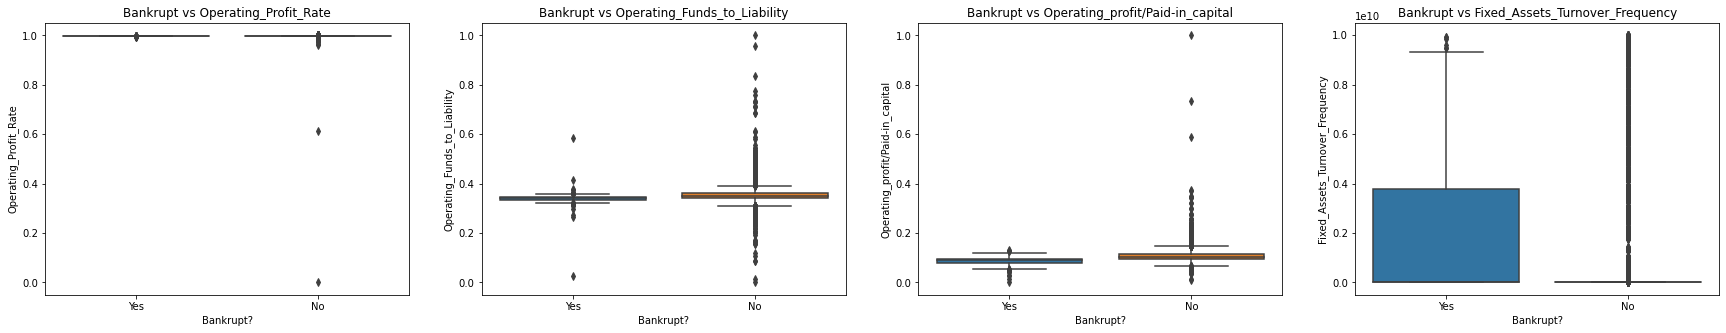

In [26]:
fig, axs = plt.subplots(ncols=4, figsize=(30,5))
sns.boxplot(x='Bankrupt?',y='Operating_Profit_Rate', data=cat_data, ax=axs[0])
sns.boxplot(x='Bankrupt?',y='Operating_Funds_to_Liability', data=cat_data, ax=axs[1])
sns.boxplot(x='Bankrupt?',y='Operating_profit/Paid-in_capital', data=cat_data, ax=axs[2])
sns.boxplot(x='Bankrupt?',y='Fixed_Assets_Turnover_Frequency', data=cat_data, ax=axs[3])
axs[0].set_title('Bankrupt vs Operating_Profit_Rate');
axs[1].set_title('Bankrupt vs Operating_Funds_to_Liability');
axs[2].set_title('Bankrupt vs Operating_profit/Paid-in_capital');
axs[3].set_title('Bankrupt vs Fixed_Assets_Turnover_Frequency');

The box plots in operation measures category presents almost no difference between bankrupt vs surviving companies. These indicators could signify that the operation measuring ratio are not a big contributing factor to determining the bankruptcy.

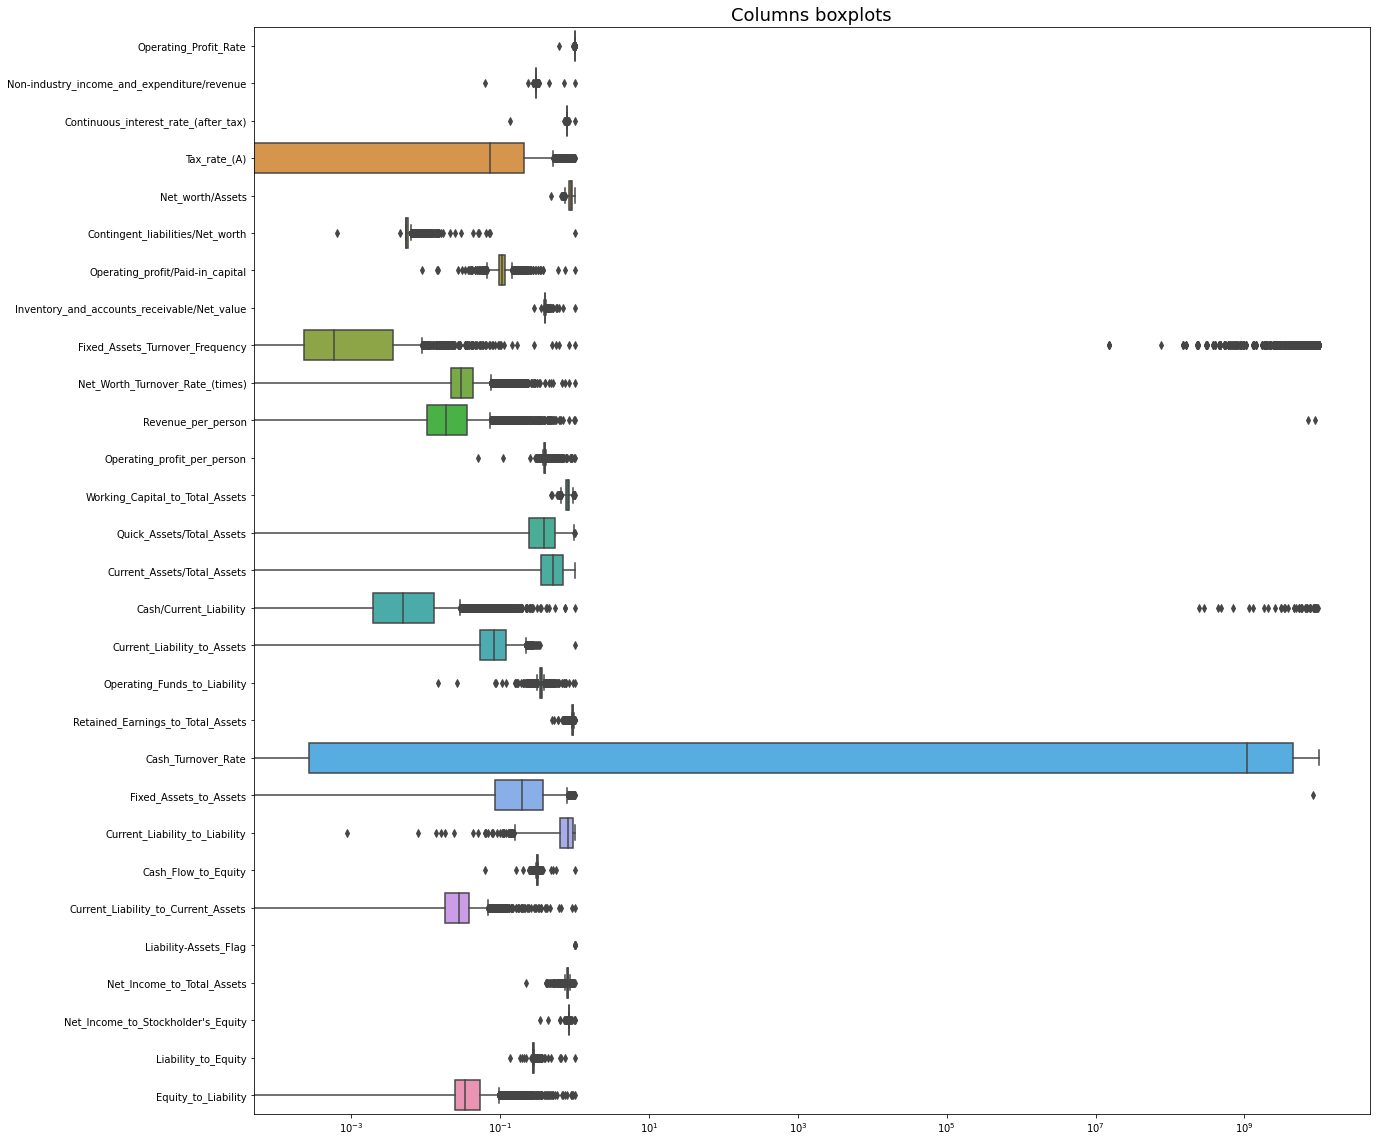

In [33]:
plt.figure(figsize=(20,20))
ax = sns.boxplot(data=cat_data, orient="h")
ax.set_title('Columns boxplots',fontsize=18)
ax.set(xscale='log')
plt.show()